# Mạng lưới cấu trúc mô hình XGboost

### BS. Lê Ngọc Khả Nhi

# Dữ liệu 

Bài thực hành sử dụng bộ dữ liệu Primary breast cancer vs Normal breast tissue từ nghiên cứu:

Matamala N, Vargas MT, González-Cámpora R, Miñambres R et al. Tumor microRNA expression profiling identifies circulating microRNAs for early breast cancer detection. Clin Chem 2015 Aug;61(8):1098-106. PMID: 26056355

Bộ dữ liệu này chứa thông tin về microRNA expression của 1926 genes, từ mô sinh thiết tuyến vú của 122 bệnh nhân ung thư vú và 11 người bình thường. 

Các bạn có thể tải dữ liệu định dạng CSV từ kaggle

https://www.kaggle.com/rhostam/primary-breast-cancer-vs-normal-breast-tissue

Sau khi tải về, bạn sẽ có 1 file CSV kích thước khoảng 2.27 Mb

In [1]:
## Xóa cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Thư viện hỗ trợ
import numpy as np
import pandas as pd
import itertools

# Đồ họa
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 12})
np.random.seed(123)

# Thư viện xgboost, mô hình phân loại
from xgboost import XGBClassifier # XGboost

# SMOTE
from imblearn.over_sampling import SMOTE

# Xuất hình vector hay PNG ?
%config InlineBackend.figure_format = 'png' # 'svg' nếu muốn xuất hình vector

# Network tools
import re
import networkx as nx

# Chuẩn bị dữ liệu

Nhi viết 1 hàm để chuẩn bị dữ liệu cho thí nghiệm, hàm này thi hành quy trình như sau:

1) Tải file 'GSE58606_data.csv' và lưu thành pd.DataFrame,

2) Recode lại outcome (target) 0 thành 1, và ngược lại (vì dữ liệu gốc mã hóa class bệnh lý = 0 và bình thường = 1)

3) Áp dụng algorithm SMOTE để cân bằng tỉ lệ 2 nhãn 0/1 (vì dữ liệu bị mất cân bằng: 122 bệnh nhân vs 11 người bình thường)

Kết quả xuất ra bao gồm dataframe gốc, tập X_train chứa features, và y_train chứa series label cho outcome

In [2]:
def Data_prep(file_path: str):
    
    df = pd.read_csv(file_path)
    
    df['target'] = df['target'].map({0:1, 1:0})
    
    X = df.drop(['target_actual','target'], axis = 1)
    Y = df.target
    
    smote = SMOTE()
    X_train, y_train = smote.fit_sample(X, Y)
    
    return df, X_train, y_train

In [3]:
df, X_train, y_train = Data_prep('GSE58606_data.csv')

Đây là nội dung dữ liệu gốc:

In [4]:
df.head()

,4040 : hsa-miR-9-5p,4610 : hsa-miR-126-3p,4700 : hsa-miR-140-5p,5250 : hsa-miR-105-5p,6880 : hsa-miR-297,9938 : hsa-let-7i-5p,10138 : hsa-miR-130a-3p,10306 : hsa-miR-146b-5p,10901 : hsa_negative_control_6,10902 : hsa_negative_control_7,...,169411 : hsa-miR-205-3p,169412 : hsa-miR-1260a,169414 : hsa-miR-525-5p,169415 : hsa-miR-187-5p,169416 : hsa-miRPlus-A1086,169417 : hsa-miR-551b-5p,169419 : hsa-miR-300,169420 : hsa-miR-193b-5p,target,target_actual
0,6.877643,8.080215,6.245265,6.304782,6.686064,7.805950,6.814781,7.146955,6.170680,6.129586,...,7.176684,7.724408,6.035476,6.255048,6.572019,6.251777,5.873303,6.362097,0,primary breast cancer
1,6.544287,6.882722,5.874236,6.324987,6.638048,6.946567,6.488574,6.690773,6.160272,6.104929,...,7.249094,7.308890,6.021796,6.902473,6.347183,6.625569,6.004899,6.560329,0,primary breast cancer
2,6.879713,6.885387,5.958748,6.317687,6.664956,7.266728,6.965078,6.969818,6.226957,6.124874,...,7.404104,7.466418,5.977962,6.484571,6.259788,6.226957,5.815442,6.354622,0,primary breast cancer
3,6.943464,7.972342,6.026106,6.425266,6.761433,8.010618,6.441945,6.679714,6.471518,6.264685,...,6.811846,8.601204,6.021790,5.912640,6.002302,5.999349,5.811117,6.306704,0,primary breast cancer
4,7.097877,9.014977,7.127656,6.566482,6.990273,8.746360,8.087122,7.680249,6.499892,6.226560,...,6.361862,7.570751,5.967819,5.821186,6.550078,5.947994,5.828413,6.288596,0,primary breast cancer


Có 122 bệnh nhân và 11 người bình thường

In [5]:
df.target_actual.value_counts()

primary breast cancer    122
normal breast tissue      11
Name: target_actual, dtype: int64

Sau khi cân bằng với SMOTE, tập X_train có 1926 features của 244 instances, tương ứng ta có 244 nhãn trong y_train

In [7]:
X_train.shape, y_train.shape

((244, 1926), (244,))

# Chuẩn bị class mô hình XGBoost cho thí nghiệm

Mục tiêu của thí nghiệm là sử dụng algorithm XGboost để thiết lập một mô hình XGBoost Classifier nhị phân, có khả năng phân loại 2 nhãn Ung thư vú nguyên phát (1) và Bình thường (0). Tuy nhiên, mục tiêu thực sự của chúng ta không phải là sử dụng mô hình này như công cụ chẩn đoán, nhưng làm phương tiện trung gian để trả lời 2 câu hỏi:

1) Những genes nào là quan trọng nhất trong số 1926 genes, cho phép phân biệt mô lành tính và ung thư ? Khái niệm (quan trọng' của một gene được định nghĩa bằng tần suất tham gia của gene đó vào các booster trong mô hình Xgboost (định tính), và giá trị gain trung bình (định lượng) của gene đó.

2) Mạng lưới hợp tác giữa các genes quan trọng này ? Định nghĩa về sự hợp tác giữa 2 genes là khi chúng cùng tham gia vào 1 booster cây quyết định trong mô hình XGboost. Nói cách khác, ta đang mô tả cấu trúc của mô hình Xgboost.

Để thực hiện mục tiêu này, Nhi viết code để tạo ra 1 class XGBC, ghi chú: class này thừa kế tất cả tính năng và thuộc tính từ class XGBClassifier nên có thể dùng để khởi tạo object mô hình XGboost classifier và huấn luyện nó bằng method fit() như cú pháp của scikitlearn.

Nhi sẽ tạo ra thêm vài method để thêm tính năng:

1) Chuyển nội dung mô hình xgboost sau huấn luyện xong thành 1 network và vẽ hình network này
2) Vẽ biểu đồ của 50 genes quan trọng nhất, xét theo tiêu chí giá trị gain trung bình.

Cụ thể như sau:

## Chuyển boosters thành network

xgb_to_network() sẽ dùng method get_booster() để trích xuất thông tin về các booster trong mô hình xgboost, và sao lưu thành 1 file txt. Thông tin về các booster có cấu trúc như sau:

    booster[0]:
    0:[f403<6.64946461] yes=1,no=2,missing=1,gain=23.8403015,cover=33.25
        1:[f581<6.46650696] yes=3,no=4,missing=3,gain=3.62321472,cover=30.5
            3:leaf=-0.580327868,cover=29.5
            4:leaf=-0,cover=1
        2:[f0<7.15805626] yes=5,no=6,missing=5,gain=1.18787885,cover=2.75
            5:leaf=0.381818205,cover=1.75
            6:leaf=-0,cover=1
    booster[1]:
    0:[f1389<6.09411621] yes=1,no=2,missing=1,gain=15.5025101,cover=30.8370247
        1:[f10<6.2456975] yes=3,no=4,missing=3,gain=0.229766846,cover=27.4590511
            3:leaf=-0.454397917,cover=26.2887363
            4:leaf=-0.129303187,cover=1.17031479
        2:[f3<6.61258602] yes=5,no=6,missing=5,gain=3.72619581,cover=3.37797332
            5:leaf=-0.161031634,cover=1.18134141
            6:leaf=0.369213343,cover=2.19663191
            
Trong đó nhóm 'fxxx', là tên của features trong tập X_train, thí dụ f403 là feature thứ 403. Chú ý; ta không dùng trực tiếp tên của genes trong dataframe X_train, mà chỉ huấn luyện mô hình bằng numpy array X_train.values, để thống nhất cấu trúc tên features trong booster, cho phép dùng regex để định vị chúng dễ dàng hơn sau này.

Tiếp theo, ta sẽ tạo ra 1 dictionary để bắt cặp tên của genes trong X_train.columns và hệ thống tên features trong booster (fxxx), dictionary này có vai trò như từ điển tên features và có thể phiên dịch từ hệ thống tên features trong booster thành tên của genes.

Sau đó, Nhi dùng regular expression để định vị lần lượt:

Mỗi booster , bằng pattern: 'booster\[[0-9]+\]'

và trong mỗi booster, tìm lần lượt: 

+ Tên feature với pattern: '\[f([0-9]+)<([0-9]+.[0-9]+)\]'

+ Giá trị gain với pattern: 'gain=([0-9]+.[0-9]+)'

+ Giá trị cover với pattern: 'cover=([0-9]+.[0-9]+)'

Như vậy, ta có thể xác định feature (gene) nào tham gia vào booster nào, và booster đó có gain, cover bao nhiêu

Bước tiếp theo, ta chuyển thông tin này thành 1 network với quy luật như sau:

Mỗi feature (gene) là 1 node trong network, mỗi node có 6 thuộc tính: tên node, tần suất hiện diện trong booster (count),tổng giá trị gain và cover, giá trị gain trung bình (avg_gain), giá trị cover trung bình (avg_cover)

Mỗi lần 1 feature, gene tham gia vào 1 booster, tần suất count của node đó sẽ tăng thêm 1 điểm, giá trị gain và cover tổng sẽ được cập nhật

Mỗi khi 2 features (genes) cùng tham gia vào 1 booster, sẽ tạo ra 1 edge trên network, đồng thời giá trị gain và cover trung bình của mỗi node được cập nhật bằng cách lấy gain và cover tổng chia cho count.

Sử dụng vòng lặp, ta sẽ xây dựng được network này từ thông tin mà regex xuất ra.

Sau khi đã có network G, ta sẽ dễ dàng vẽ được nó ra thành hình ảnh.

## Phân tích variable importance (vimp)

Tiếp theo, method vimp_plot() làm quy trình sau đây:

Trước hết, tạo ra 1 dataframe vimp_df rỗng, với mỗi hàng là 1 gene, và 6 cột : 'gene','count','gain','cover','avg_gain','avg_cover', tương ứng với tên của gene, tần suất hiện diện trong boosters, tổng giá trị gain, cover, giá trị gain, cover trung bình.

Sau đó dataframe này sẽ được điền giá trị nhờ đọc thông tin bên trong network G

Sau khi đã điền xong dataframe vimp_plot(), ta dễ dàng vẽ được barplot để hiển thị giá trị gain trung bình của 50 genes quan trọng nhất.

In [ ]:
booster[0]:
0:[f403<6.64946461] yes=1,no=2,missing=1,gain=23.8403015,cover=33.25
	1:[f581<6.46650696] yes=3,no=4,missing=3,gain=3.62321472,cover=30.5
		3:leaf=-0.580327868,cover=29.5
		4:leaf=-0,cover=1
	2:[f0<7.15805626] yes=5,no=6,missing=5,gain=1.18787885,cover=2.75
		5:leaf=0.381818205,cover=1.75
		6:leaf=-0,cover=1
booster[1]:
0:[f1389<6.09411621] yes=1,no=2,missing=1,gain=15.5025101,cover=30.8370247
	1:[f10<6.2456975] yes=3,no=4,missing=3,gain=0.229766846,cover=27.4590511
		3:leaf=-0.454397917,cover=26.2887363
		4:leaf=-0.129303187,cover=1.17031479
	2:[f3<6.61258602] yes=5,no=6,missing=5,gain=3.72619581,cover=3.37797332
		5:leaf=-0.161031634,cover=1.18134141
		6:leaf=0.369213343,cover=2.19663191

In [25]:
class XGBC(XGBClassifier):
    
    def __init__(self,
                 objective='binary:logistic',
                 **kwargs):
        
        super(XGBC, self).__init__(objective,**kwargs)
        
    def xgb_to_network(self):
        
        features = self.features
        txt_name = self.model_name
        
        self.get_booster().dump_model(f"{txt_name}.txt", with_stats=True)
        
        # read the contents of the file

        with open(f"{txt_name}.txt", 'r') as f:
            txt_model = f.read()

        feat_list = {k:v for k,v in zip([f'f{i}' for i in range(len(features))], features)}

        p = re.compile('booster\[[0-9]+\]:')
        search_iter = p.finditer(txt_model)
        boost_list = [m.span() for m in search_iter]

        feat_set = []
        
        for b in range(len(boost_list)-1):
                booster = txt_model[boost_list[b][1]: boost_list[b+1][0]]
                b_feat = re.findall('\[f([0-9]+)<([0-9]+.[0-9]+)\]', booster)
                b_gain = re.findall('gain=([0-9]+.[0-9]+)', booster)
                b_cover = re.findall('cover=([0-9]+.[0-9]+)', booster)
                b_feat = [(feat_list[f'f{k[0]}'],k[1],ga,cv) for k,ga,cv in zip(b_feat,b_gain,b_cover)]
                feat_set.append(b_feat)

        G = nx.Graph()

        for booster in feat_set:

            feats = [ft[0] for ft in booster]
            f_gain = [float(ft[2]) for ft in booster]
            f_cover = [float(ft[3]) for ft in booster]

            for v,ga,cv in zip(feats,f_gain, f_cover):
                try:
                    G.nodes[v]['count'] += 1
                    G.nodes[v]['gain'] += ga
                    G.nodes[v]['cover'] += cv
                except KeyError:
                    G.add_node(v)
                    G.nodes[v]['count'] = 1
                    G.nodes[v]['gain'] = ga
                    G.nodes[v]['cover'] = cv

                for w in feats:
                    try:
                        G.edges[v, w]['count'] += 1
                    except KeyError:
                        G.add_edge(v, w, count=1)

        for n,d in G.nodes(data = True):
            G.nodes[n]['avg_gain'] = d['gain']/d['count']
            G.nodes[n]['avg_cover'] = d['cover']/d['count']

        return G
    
    def draw_xgb_network(self, features, model_name):
        
        self.features = features
        self.model_name = model_name
        
        G = self.xgb_to_network()
        self.G = G
            
        plt.rcParams.update({
                'figure.figsize': (14,14),
                'axes.spines.right': False,
                'axes.spines.left': False,
                'axes.spines.top': False,
                'axes.spines.bottom': False})

        node_sizes = 20*np.array([d['avg_gain'] for n,d in G.nodes(data = True)])
        weights = np.log(2*np.array([d['count'] for s, t, d in G.edges(data=True)]))
        degrees = np.log(np.array([val for (node, val) in G.degree()]))

        pos=nx.kamada_kawai_layout(G)

        nx.draw_networkx_nodes(G, pos, 
                                   node_size = node_sizes , 
                                   alpha = 0.5, 
                                   node_color=degrees,
                                   cmap = plt.cm.rainbow)

        nx.draw_networkx_labels(G, pos, 
                                    font_size = 5, 
                                    font_color = 'black', 
                                    alpha = 0.5)

        nx.draw_networkx_edges(G, pos, 
                                   edge_color=weights,
                                   edge_cmap=plt.cm.rainbow_r,
                                   width = weights, 
                                   alpha=0.3)
        
    @staticmethod
    def show_values_on_bars(axs, h_v="v", space=0.4):
        
        def _show_on_single_plot(ax):
            if h_v == "v":
                for p in ax.patches:
                    _x = p.get_x() + p.get_width()/2
                    _y = p.get_y() + p.get_height()
                    value = int(p.get_height())
                    ax.text(_x, _y, value, ha="center") 
            elif h_v == "h":
                for p in ax.patches:
                    _x = p.get_x() + p.get_width() + float(space)
                    _y = p.get_y() + p.get_height()
                    value = round(float(p.get_width()),3)
                    ax.text(_x, _y, value, ha = 'left')

        if isinstance(axs, np.ndarray):
            for idx, ax in np.ndenumerate(axs):
                _show_on_single_plot(ax)
        else:
            _show_on_single_plot(axs)
    
    def vimp_plot(self):
        
        vimp_df = pd.DataFrame(dict.fromkeys(['gene','count','gain','cover','avg_gain','avg_cover']), index = [])

        for n in list(self.G.nodes.data()):

            vimp_df = pd.concat([vimp_df,
                                pd.DataFrame(n[1], index = [n[0]])
                                ], axis = 0)

        vimp_df.gene = [i.split(':')[1] for i in vimp_df.index]
        
        self.vimp_df = vimp_df
        
        sns.set_palette(sns.color_palette("YlOrRd_r", 50).as_hex())

        vimp_df.sort_values(by = 'avg_gain', ascending=False, inplace=True)
        y = vimp_df.gene.values[0:50]
        x = vimp_df.avg_gain.values[0:50]

        plt.figure(figsize=(5,10))
        matplotlib.rcParams.update({'font.size': 10})
        ax = sns.barplot(x,y)

        self.show_values_on_bars(ax, h_v="h", space=0.2)
        plt.xlabel('Giá trị Gain trung bình')
        plt.ylabel(f'{len(x)} genes quan trọng nhất')
        
        plt.show()

# Tiến hành thí nghiệm

## Khởi tạo mô hình XGBC

Ghi chú: Nếu máy tính của bạn không có GPU, tree_method = 'hist', không cần argument predictor = 'gpu_predictor'

In [26]:
xgb_mod = XGBC(objective='binary:logistic',
               booster='dart',
                        learning_rate = 0.01,
                        gamma = 0.1,
                        n_estimators = 500,
                        subsample = 1.0,
                        colsample_bytree = 0.5,
                        colsample_bylevel = 0.5,
                        colsample_bynode = 0.5,
                        tree_method = "gpu_hist",
                        max_depth = 5,
                        min_child_weight = 1,
                        eval_metric = 'logloss',
                        predictor = 'gpu_predictor')

## Huấn luyện mô hình

Chú ý: dùng X_train.values thay vì X_train, như đã giải thích.

In [27]:
xgb_mod.fit(X = X_train.values,
            y = y_train.values)

XGBC(base_score=0.5, booster='dart', colsample_bylevel=0.5,
     colsample_bynode=0.5, colsample_bytree=0.5, eval_metric='logloss',
     gamma=0.1, gpu_id=0, importance_type='gain', interaction_constraints='',
     learning_rate=0.01, max_delta_step=0, max_depth=5, min_child_weight=1,
     missing=nan,
     monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
     n_estimators=500, n_jobs=0, num_parallel_tree=1, predictor='gpu_predictor',
     random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
     subsample=1.0, tree_method='gpu_hist', validate_parameters=1,
     verbosity=None)

## Chuyển mô hình thành network

Chú thích:

Trong network này, mỗi node là 1 gene, mỗi edge tượng trưng cho sự hợp tác giữa 2 gene trong mô hình XGBC. Tần suất hiện diện trong nhiều booster càng cao, thì edge càng dày, màu càng đậm.

Kích thước của node tương ứng với avg_gain trung bình của nó, Node càng có gain trung bình cao, kích thước của nó càng lớn.

Màu sắc của node biểu thị cho khả năng liên kết, node có càng nhiều liên kết với node khác, màu càng nóng (đỏ, cam, vàng), node đơn độc ít liên kết màu càng lạnh (tím, xanh, lục).

Node càng có nhiều liên kết, vị trí của nó càng nằm gần trung tâm network, node ít liên kết sẽ nằm ngoài rìa của network.

Như vậy những gene quan trọng khi chúng tham gia vào nhiều booster, từ đó có nhiều liên kết với gene khác, có gain trung bình cao. Như vậy tương ứng với các node nằm gần trung tâm, kích thước lớn, màu đậm.

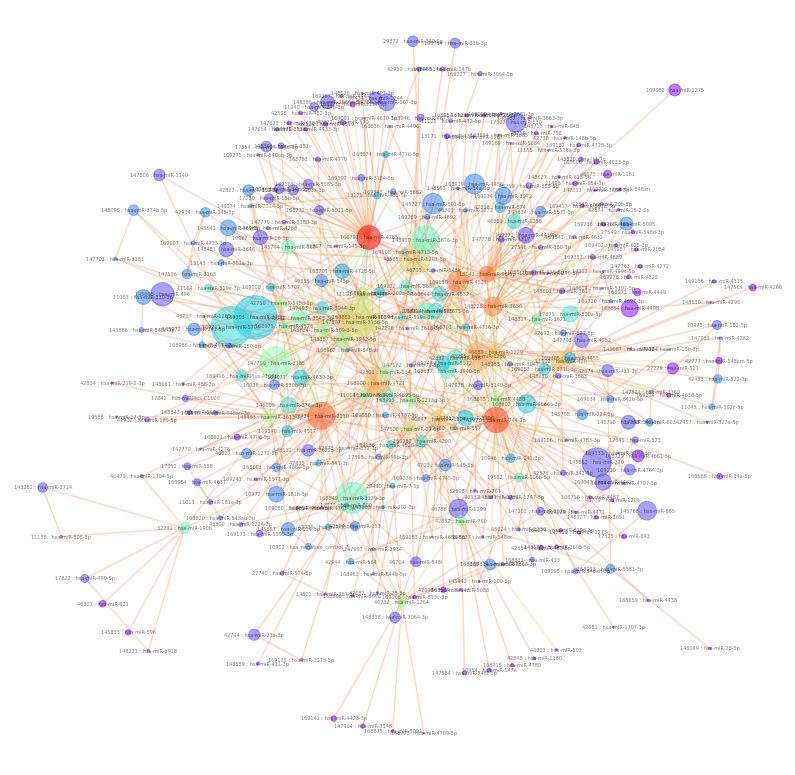

In [30]:
xgb_mod.draw_xgb_network(features = X_train.columns, 
                         model_name = 'xgb_mod')

## Biểu đồ VIMP cho 50 genes quan trọng nhất

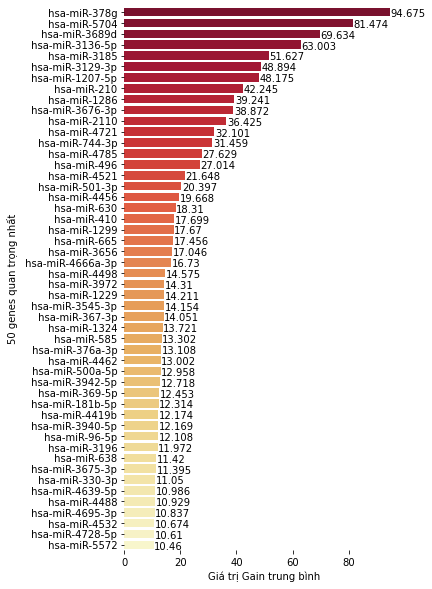

In [29]:
xgb_mod.vimp_plot()

Dữ liệu gốc vimp_df cho biểu đồ này được lưu lại như 1 thuộc tính của object mô hình, xgb_mod. Nếu khảo sát nó, ta sẽ nhận ra điều thú vị là mô hình XGBC đã tự động lọc ra 311 genes và chỉ cần chừng đó cho mục tiêu phân loại. Toàn bộ 311 genes này được trình bày trong network. Như vậy bản thân phương pháp Xgboost có thể được dùng cho mục tiêu diễn dịch, nhằm phát hiện ra một số ít genes quan trọng nhất từ tập hợp 1926 genes ban đầu.

In [31]:
vimp_df = xgb_mod.vimp_df

vimp_df

,gene,count,gain,cover,avg_gain,avg_cover
169303 : hsa-miR-378g,hsa-miR-378g,2,189.349948,97.398289,94.674974,48.699144
169211 : hsa-miR-5704,hsa-miR-5704,3,244.423176,145.673088,81.474392,48.557696
168883 : hsa-miR-3689d,hsa-miR-3689d,11,765.976467,491.994665,69.634224,44.726788
147897 : hsa-miR-3136-5p,hsa-miR-3136-5p,10,630.030958,369.462810,63.003096,36.946281
147709 : hsa-miR-3185,hsa-miR-3185,7,361.387192,257.253909,51.626742,36.750558
...,...,...,...,...,...,...
169333 : hsa-miR-3194-3p,hsa-miR-3194-3p,1,0.129130,3.010508,0.129130,3.010508
46737 : hsa-miR-1265,hsa-miR-1265,1,0.126209,1.035088,0.126209,1.035088
169001 : hsa-miR-4670-5p,hsa-miR-4670-5p,1,0.121481,1.016782,0.121481,1.016782
148639 : hsa-miR-4298,hsa-miR-4298,1,0.121107,2.082612,0.121107,2.082612


Ta có thể sử dụng Cluster heatmap để thăm dò cho 100 gene quan trọng nhất trong số 311 genes kể trên. Hình ảnh thu được như sau:

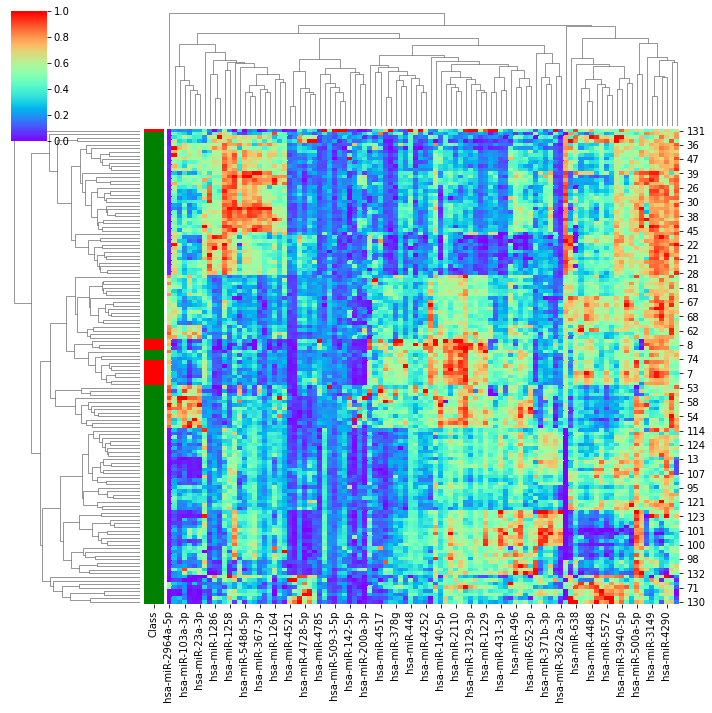

In [34]:
Xhm = df.drop(['target_actual','target'], axis = 1)
Xhm.columns = [i.split(':')[1]  for i in Xhm.columns]
Xhm = Xhm[list(vimp_df.gene)[:101]]
Xhm['Class'] = df.target

col_dict = dict(zip(Xhm.Class.unique(), ['green','red']))

row_colors = Xhm.Class.map(col_dict)

g = sns.clustermap(Xhm.drop(['Class'], axis = 1), 
                   row_colors=row_colors, 
                   standard_scale=1,
                  metric='euclidean', 
                   cmap=plt.cm.rainbow)

# Tổng kết

Bài thực hành đến đây là hết, những thông điệp chính bao gồm:

1) Ngoài công dụng phân loại, ta có thể dùng mô hình XGboost cho mục tiêu diễn dịch, đặc biệt dữ liệu có dimensionality cao với hàng ngàn biến số. Lúc này, mô hình XGBoost cho phép phân lập được một tập dữ liệu nhỏ hơn gồm 1 số ít những features quan trọng nhất.

2) Có thể trình bày cấu trúc của bất cứ mô hình XGboost nào thành một network; phương pháp này sẽ cung cấp nhiều thông tin hữu ích cả về ý nghĩa giải thích cấu trúc/cơ chế của mô hình, và ý nghĩa của mục tiêu diễn dịch.